In [1]:
%matplotlib inline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [2]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
data = pd.read_csv('월별공급량및비중all.csv')
print(data)
data["ID"] = pd.date_range("1996-01-01", "2020-12-01", freq="MS")

     YEAR  MONTH  도시가스(톤)_민수용  도시가스(톤)_산업용  도시가스(톤)_총합(민수용+산업용)    민수용비중  \
0    1996      1     605519.0      83809.0             689328.0  0.87842   
1    1996      2     566323.0      70427.0             636750.0  0.88940   
2    1996      3     477514.0      62652.0             540166.0  0.88401   
3    1996      4     337794.0      47050.0             384844.0  0.87774   
4    1996      5     184522.0      30709.0             215231.0  0.85732   
..    ...    ...          ...          ...                  ...      ...   
295  2020      8     398661.0     457970.0             856631.0  0.46538   
296  2020      9     380235.0     525619.0             905853.0  0.41975   
297  2020     10     616682.0     600890.0            1217571.0  0.50649   
298  2020     11    1093747.0     665901.0            1759648.0  0.62157   
299  2020     12    1921404.0     811928.0            2733332.0  0.70295   

       산업용비중  
0    0.12158  
1    0.11060  
2    0.11599  
3    0.12226  
4    0.14268

In [4]:
civil = data[['YEAR', 'MONTH', "도시가스(톤)_민수용"]]
civil.index = data["ID"]
print(civil.head())

            YEAR  MONTH  도시가스(톤)_민수용
ID                                  
1996-01-01  1996      1     605519.0
1996-02-01  1996      2     566323.0
1996-03-01  1996      3     477514.0
1996-04-01  1996      4     337794.0
1996-05-01  1996      5     184522.0


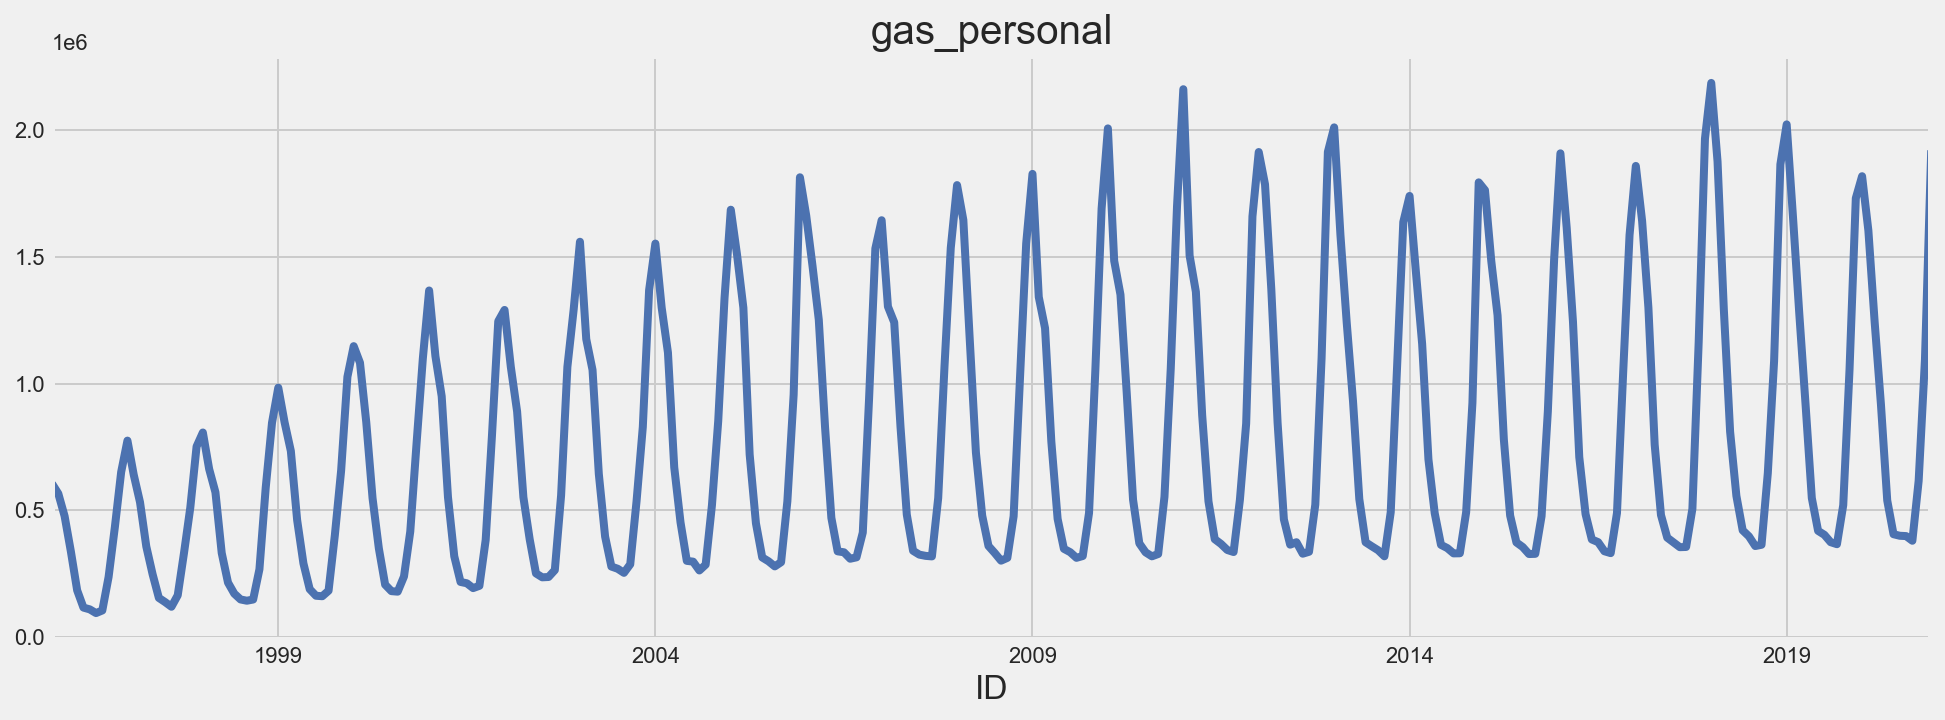

In [5]:
civil['도시가스(톤)_민수용'].plot(style='-',
          figsize=(15, 5),
          color=color_pal[0],
          title='gas_personal')

plt.show()

In [6]:
split_date = '2017-12-01'
train = civil.loc[civil.index <= split_date].copy()
test = civil.loc[civil.index > split_date].copy()

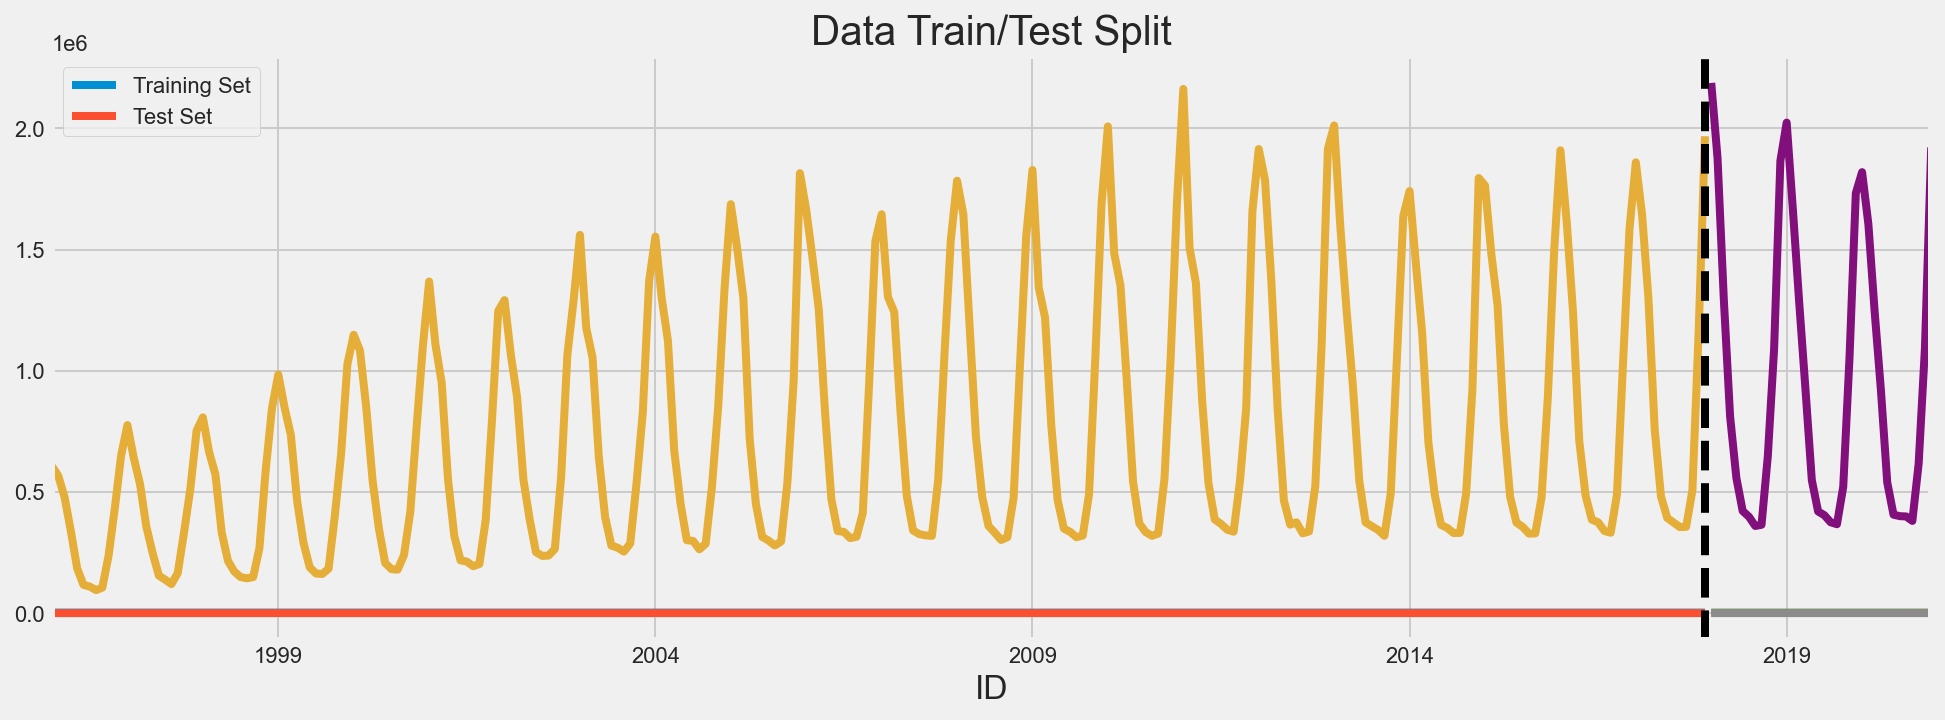

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=7, test_size=12, gap=0)
civil = civil.sort_index()

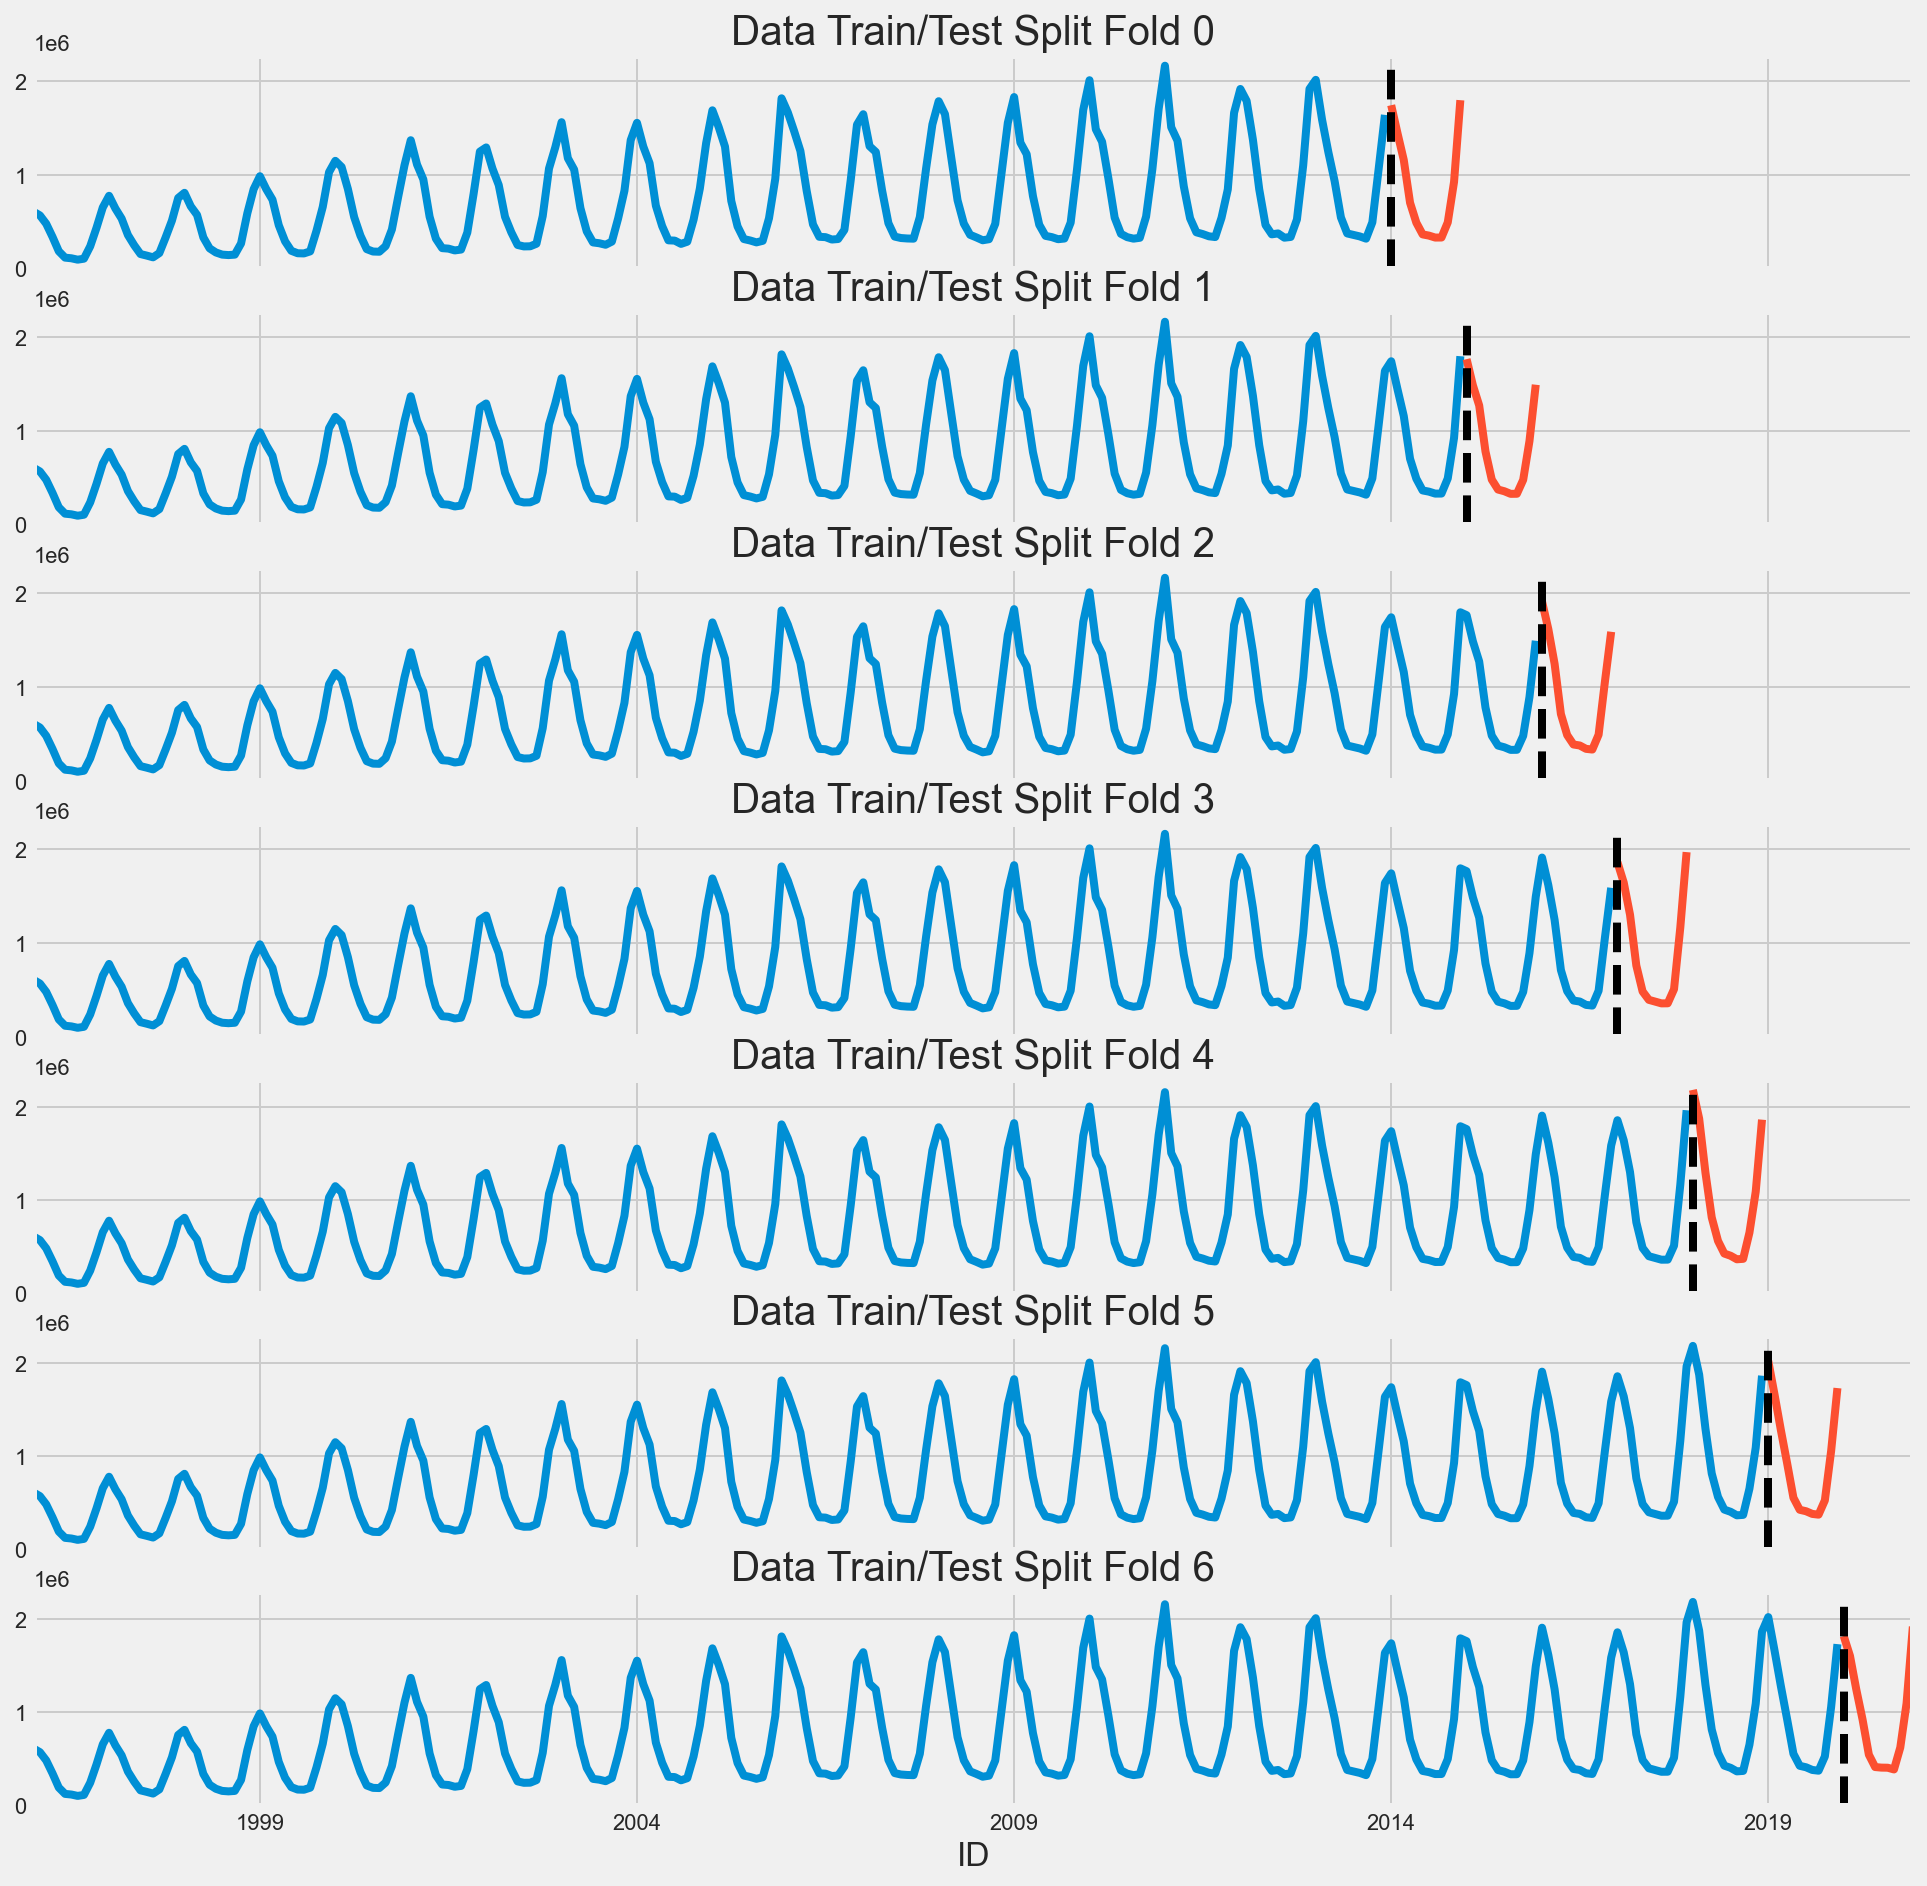

In [9]:
fig, axs = plt.subplots(7, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(civil):
    train = civil.iloc[train_idx]
    test = civil.iloc[val_idx]
    train['도시가스(톤)_민수용'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['도시가스(톤)_민수용'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [10]:
def add_lags(df):
    df['lag1'] = df['도시가스(톤)_민수용'].shift(12)
    df['lag2'] = df['도시가스(톤)_민수용'].shift(24)
    return df

In [11]:
civil = add_lags(civil)

In [12]:
tss = TimeSeriesSplit(n_splits=7, test_size=12, gap=0)
civil = civil.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(civil):
    train = civil.iloc[train_idx]
    test = civil.iloc[val_idx]

    FEATURES = ['MONTH', 'lag1','lag2']
    TARGET = '도시가스(톤)_민수용'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=460,
                           objective='reg:squarederror',
                           max_depth=3,
                           eval_metric='mae',
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-mae:708231.63122	validation_1-mae:834893.56250
[100]	validation_0-mae:271401.70121	validation_1-mae:270673.26953
[200]	validation_0-mae:113245.50434	validation_1-mae:89136.63542
[300]	validation_0-mae:59018.86827	validation_1-mae:62342.88281
[400]	validation_0-mae:41569.08456	validation_1-mae:79931.77344
[459]	validation_0-mae:37500.30888	validation_1-mae:86589.11198
[0]	validation_0-mae:714902.22841	validation_1-mae:826873.92708
[100]	validation_0-mae:273466.56884	validation_1-mae:294380.22526
[200]	validation_0-mae:114410.79434	validation_1-mae:89680.28906
[300]	validation_0-mae:60082.93627	validation_1-mae:36784.67448
[400]	validation_0-mae:43978.52015	validation_1-mae:35742.20573
[459]	validation_0-mae:40493.23814	validation_1-mae:39019.20573
[0]	validation_0-mae:720498.75788	validation_1-mae:868480.43750
[100]	validation_0-mae:275168.35003	validation_1-mae:327126.25260
[200]	validation_0-mae:114167.61908	validation_1-mae:135953.12240
[300]	validation_0-mae:59922.8

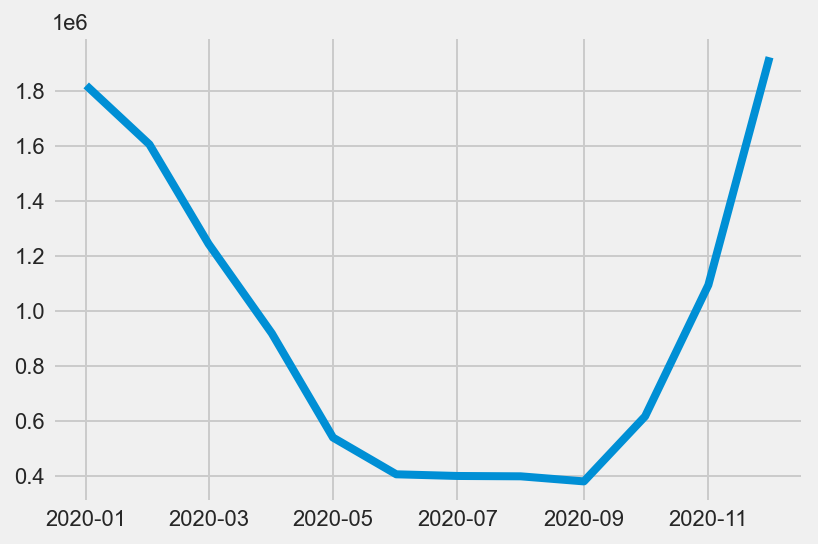

In [13]:
plt.plot(y_test)

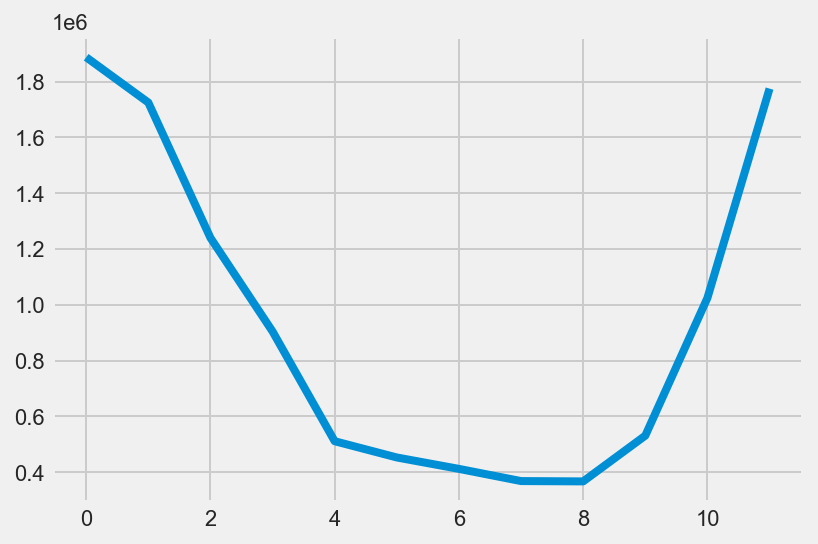

In [14]:
plt.plot(y_pred)

In [15]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 92592.9128
Fold scores:[129618.35009637885, 63459.00565697836, 60855.23274068962, 106575.91193766177, 147102.4164640553, 71530.77920725504, 69008.6935458452]


In [16]:
FEATURES = ['MONTH', 'lag1','lag2']
TARGET = '도시가스(톤)_민수용'

X_all = civil[FEATURES]
y_all = civil[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=460,
                       objective='reg:squarederror',
                       max_depth=3,
                       eval_metric='mae',
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-mae:761865.68784
[100]	validation_0-mae:288556.47958
[200]	validation_0-mae:117106.29302
[300]	validation_0-mae:61244.24302
[400]	validation_0-mae:46442.62635
[459]	validation_0-mae:43208.10599


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=460, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [17]:
civil.index.max()

Timestamp('2020-12-01 00:00:00')

In [18]:
future = pd.date_range('2021-01-01','2021-12-01', freq='MS')
future_civil = pd.DataFrame(index=future)
future_civil['MONTH'] = future.month
future_civil['isFuture'] = True
civil['isFuture'] = False
civil_and_future = pd.concat([civil, future_civil])
civil_and_future = add_lags(civil_and_future)
print(civil_and_future)

              YEAR  MONTH  도시가스(톤)_민수용       lag1       lag2  isFuture
1996-01-01  1996.0      1     605519.0        NaN        NaN     False
1996-02-01  1996.0      2     566323.0        NaN        NaN     False
1996-03-01  1996.0      3     477514.0        NaN        NaN     False
1996-04-01  1996.0      4     337794.0        NaN        NaN     False
1996-05-01  1996.0      5     184522.0        NaN        NaN     False
...            ...    ...          ...        ...        ...       ...
2021-08-01     NaN      8          NaN   398661.0   374639.0      True
2021-09-01     NaN      9          NaN   380235.0   366621.0      True
2021-10-01     NaN     10          NaN   616682.0   520739.0      True
2021-11-01     NaN     11          NaN  1093747.0  1055013.0      True
2021-12-01     NaN     12          NaN  1921404.0  1732147.0      True

[312 rows x 6 columns]


In [19]:
future_w_features = civil_and_future.query('isFuture').copy()
print(future_w_features)

            YEAR  MONTH  도시가스(톤)_민수용       lag1       lag2  isFuture
2021-01-01   NaN      1          NaN  1819123.0  2023662.0      True
2021-02-01   NaN      2          NaN  1604680.0  1660132.0      True
2021-03-01   NaN      3          NaN  1243141.0  1279302.0      True
2021-04-01   NaN      4          NaN   918206.0   920035.0      True
2021-05-01   NaN      5          NaN   539517.0   548871.0      True
2021-06-01   NaN      6          NaN   406010.0   419341.0      True
2021-07-01   NaN      7          NaN   399937.0   403664.0      True
2021-08-01   NaN      8          NaN   398661.0   374639.0      True
2021-09-01   NaN      9          NaN   380235.0   366621.0      True
2021-10-01   NaN     10          NaN   616682.0   520739.0      True
2021-11-01   NaN     11          NaN  1093747.0  1055013.0      True
2021-12-01   NaN     12          NaN  1921404.0  1732147.0      True


In [20]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [21]:
#print(future_w_features['pred'])
#print(future_w_features.index)
civil_and_future.loc[future_w_features.index, '도시가스(톤)_민수용']=future_w_features['pred']
civil_and_future['isFuture'] = False
print(civil_and_future)

              YEAR  MONTH   도시가스(톤)_민수용       lag1       lag2  isFuture
1996-01-01  1996.0      1  6.055190e+05        NaN        NaN     False
1996-02-01  1996.0      2  5.663230e+05        NaN        NaN     False
1996-03-01  1996.0      3  4.775140e+05        NaN        NaN     False
1996-04-01  1996.0      4  3.377940e+05        NaN        NaN     False
1996-05-01  1996.0      5  1.845220e+05        NaN        NaN     False
...            ...    ...           ...        ...        ...       ...
2021-08-01     NaN      8  4.096708e+05   398661.0   374639.0     False
2021-09-01     NaN      9  4.096708e+05   380235.0   366621.0     False
2021-10-01     NaN     10  6.311059e+05   616682.0   520739.0     False
2021-11-01     NaN     11  1.042514e+06  1093747.0  1055013.0     False
2021-12-01     NaN     12  1.749837e+06  1921404.0  1732147.0     False

[312 rows x 6 columns]


In [22]:
def hyun_pred(start, finish):
    global civil_and_future
    future = pd.date_range(start, finish, freq='MS')
    future_civil = pd.DataFrame(index=future)
    future_civil['MONTH'] = future.month
    future_civil['isFuture'] = True
    civil_and_future = pd.concat([civil_and_future, future_civil])
    civil_and_future = add_lags(civil_and_future)

    future_w_features = civil_and_future.query('isFuture').copy()
    future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
    civil_and_future.loc[future_w_features.index, '도시가스(톤)_민수용']=future_w_features['pred']
    civil_and_future['isFuture'] = False

    return civil_and_future

In [23]:
for i in pd.date_range('2022-01-01', '2035-01-01',freq='AS'):
    for j in pd.date_range(i, periods=12, freq='MS'):
        continue
    civil_and_future = hyun_pred(i, j)
    print(civil_and_future.head())
    print(civil_and_future.tail())

              YEAR  MONTH  도시가스(톤)_민수용  lag1  lag2  isFuture
1996-01-01  1996.0      1     605519.0   NaN   NaN     False
1996-02-01  1996.0      2     566323.0   NaN   NaN     False
1996-03-01  1996.0      3     477514.0   NaN   NaN     False
1996-04-01  1996.0      4     337794.0   NaN   NaN     False
1996-05-01  1996.0      5     184522.0   NaN   NaN     False
            YEAR  MONTH   도시가스(톤)_민수용          lag1       lag2  isFuture
2022-08-01   NaN      8  4.210384e+05  4.096708e+05   398661.0     False
2022-09-01   NaN      9  4.210384e+05  4.096708e+05   380235.0     False
2022-10-01   NaN     10  7.146121e+05  6.311059e+05   616682.0     False
2022-11-01   NaN     11  1.034082e+06  1.042514e+06  1093747.0     False
2022-12-01   NaN     12  1.738897e+06  1.749837e+06  1921404.0     False
              YEAR  MONTH  도시가스(톤)_민수용  lag1  lag2  isFuture
1996-01-01  1996.0      1     605519.0   NaN   NaN     False
1996-02-01  1996.0      2     566323.0   NaN   NaN     False
1996-03-01  1

              YEAR  MONTH  도시가스(톤)_민수용  lag1  lag2  isFuture
1996-01-01  1996.0      1     605519.0   NaN   NaN     False
1996-02-01  1996.0      2     566323.0   NaN   NaN     False
1996-03-01  1996.0      3     477514.0   NaN   NaN     False
1996-04-01  1996.0      4     337794.0   NaN   NaN     False
1996-05-01  1996.0      5     184522.0   NaN   NaN     False
            YEAR  MONTH   도시가스(톤)_민수용          lag1          lag2  isFuture
2032-08-01   NaN      8  4.952107e+05  4.952107e+05  4.952107e+05     False
2032-09-01   NaN      9  4.952107e+05  4.952107e+05  4.952107e+05     False
2032-10-01   NaN     10  9.367454e+05  9.367454e+05  9.367454e+05     False
2032-11-01   NaN     11  1.034502e+06  1.034502e+06  1.034502e+06     False
2032-12-01   NaN     12  1.741438e+06  1.741438e+06  1.741438e+06     False
              YEAR  MONTH  도시가스(톤)_민수용  lag1  lag2  isFuture
1996-01-01  1996.0      1     605519.0   NaN   NaN     False
1996-02-01  1996.0      2     566323.0   NaN   NaN     F

In [24]:
print(civil_and_future.head())

              YEAR  MONTH  도시가스(톤)_민수용  lag1  lag2  isFuture
1996-01-01  1996.0      1     605519.0   NaN   NaN     False
1996-02-01  1996.0      2     566323.0   NaN   NaN     False
1996-03-01  1996.0      3     477514.0   NaN   NaN     False
1996-04-01  1996.0      4     337794.0   NaN   NaN     False
1996-05-01  1996.0      5     184522.0   NaN   NaN     False


            YEAR  MONTH   도시가스(톤)_민수용          lag1          lag2  isFuture
2023-01-01   NaN      1  1.991077e+06  1.875445e+06  1.833040e+06     False
2023-02-01   NaN      2  1.629446e+06  1.645894e+06  1.642870e+06     False
2023-03-01   NaN      3  1.233613e+06  1.233613e+06  1.233613e+06     False
2023-04-01   NaN      4  9.313156e+05  9.313156e+05  9.313156e+05     False
2023-05-01   NaN      5  5.090350e+05  5.105064e+05  5.105064e+05     False
2023-06-01   NaN      6  4.724194e+05  4.538768e+05  4.282133e+05     False
2023-07-01   NaN      7  4.210384e+05  4.210384e+05  4.096708e+05     False
2023-08-01   NaN      8  4.210384e+05  4.210384e+05  4.096708e+05     False
2023-09-01   NaN      9  4.210384e+05  4.210384e+05  4.096708e+05     False
2023-10-01   NaN     10  7.440755e+05  7.146121e+05  6.311059e+05     False
2023-11-01   NaN     11  1.034082e+06  1.034082e+06  1.042514e+06     False
2023-12-01   NaN     12  1.741438e+06  1.738897e+06  1.749837e+06     False
2024-01-01  

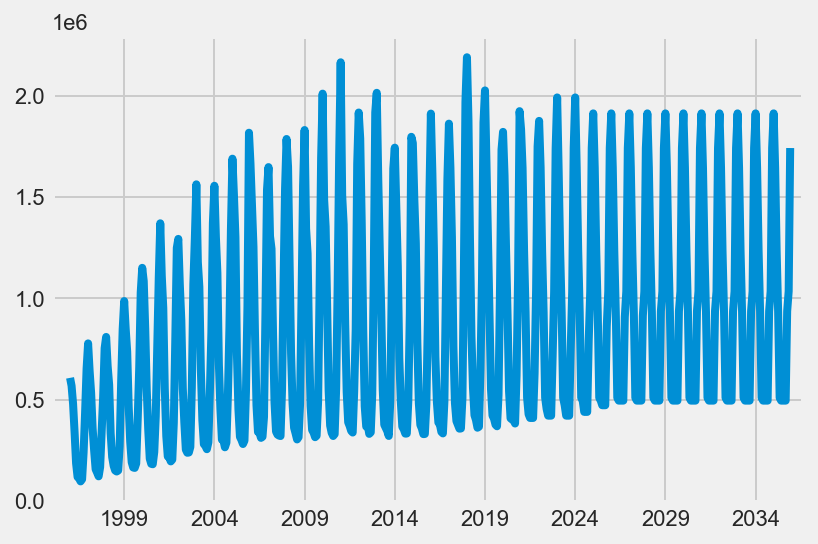

In [25]:
print(civil_and_future.iloc[324:372])
civil_and_future = civil_and_future.cumsum(1)
civil_and_future['도시가스(톤)_민수용'].plot(xlim=[300,800])
plt.show()

In [30]:
final = pd.DataFrame()
final['YEAR'] = civil_and_future[300:]['도시가스(톤)_민수용'].index.year
final['MONTH'] = civil_and_future[300:]['도시가스(톤)_민수용'].index.month
final['CIVIL'] = civil_and_future[300:]['도시가스(톤)_민수용'].values
final

,YEAR,MONTH,CIVIL
0,2021,1,1833041.375
1,2021,2,1642872.25
2,2021,3,1233615.625
3,2021,4,931319.5625
4,2021,5,510511.4375
...,...,...,...
175,2035,8,495218.65625
176,2035,9,495219.65625
177,2035,10,936755.4375
178,2035,11,1034512.8125


In [31]:
final.to_csv("xgboost.csv", mode='w', index=False)